In [ ]:
# aquire kalshi market data

import requests
import datetime
from datetime import timezone, timedelta
import csv

series = "KXBTC2025100"
ticker = "KXBTC2025100-25DEC31-100000"

BASE = "https://api.elections.kalshi.com/trade-api/v2"
CSV_PATH = "kalshi_candles_1min.csv"


def iso_to_unix(iso_str: str) -> int:
    dt = datetime.datetime.fromisoformat(iso_str.replace("Z", "+00:00"))
    return int(dt.timestamp())


# get market metadata (open_time)
market_url = f"{BASE}/markets/{ticker}"
m_resp = requests.get(market_url)
m_resp.raise_for_status()
market = m_resp.json()["market"]

open_time_iso = market["open_time"]
start_ts = iso_to_unix(open_time_iso)

# set end date to "now"
end_ts = int(datetime.datetime.now(timezone.utc).timestamp())

# prepare CSV header
header = [
    "end_period_ts",
    "open",
    "high",
    "low",
    "close",
    "mean",
    "volume",
    "open_interest"
]

# create the CSV 
with open(CSV_PATH, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)


# loop in chunks (1 day = 1440 minutes < 1000 candle limit)
current_ts = start_ts
step = 60 * 60 * 24  # one day in seconds

print("Starting download...")

while current_ts < end_ts:
    chunk_end = min(current_ts + step, end_ts)

    candles_url = f"{BASE}/series/{series}/markets/{ticker}/candlesticks"
    params = {
        "start_ts": current_ts,
        "end_ts": chunk_end,
        "period_interval": 1  # 1 min candles
    }

    resp = requests.get(candles_url, params=params)
    if resp.status_code != 200:
        print(f"Error fetching {current_ts:,} → {chunk_end:,} : {resp.text}")
        current_ts = chunk_end
        continue

    data = resp.json()
    candlesticks = data.get("candlesticks", [])

    if candlesticks:
        with open(CSV_PATH, "a", newline="") as f:
            writer = csv.writer(f)
            for c in candlesticks:
                # extract data
                price = c.get("price", {})
                row = [
                    c.get("end_period_ts"),
                    price.get("open"),
                    price.get("high"),
                    price.get("low"),
                    price.get("close"),
                    price.get("mean"),
                    c.get("volume"),
                    c.get("open_interest"),
                ]
                writer.writerow(row)

        print(f"Saved {len(candlesticks)} candles "
              f"{datetime.datetime.utcfromtimestamp(current_ts)} → {datetime.datetime.utcfromtimestamp(chunk_end)}")

    # move to next block
    current_ts = chunk_end

print("Done.")
print(f"CSV written to: {CSV_PATH}")


Starting download...


/var/folders/3m/0_xj534j5wx58mr5mds2gtlc0000gn/T/ipykernel_19452/2900610376.py:100: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  f"{datetime.datetime.utcfromtimestamp(current_ts)} → {datetime.datetime.utcfromtimestamp(chunk_end)}")


Saved 1062 candles 2025-11-25 15:00:00 → 2025-11-26 15:00:00
Saved 1002 candles 2025-11-26 15:00:00 → 2025-11-27 15:00:00
Saved 952 candles 2025-11-27 15:00:00 → 2025-11-28 15:00:00
Saved 910 candles 2025-11-28 15:00:00 → 2025-11-29 15:00:00
Saved 1188 candles 2025-11-29 15:00:00 → 2025-11-30 15:00:00
Saved 1262 candles 2025-11-30 15:00:00 → 2025-12-01 15:00:00
Saved 1357 candles 2025-12-01 15:00:00 → 2025-12-02 15:00:00


KeyboardInterrupt: 

In [ ]:
# aquire btc market data

import requests
import datetime
from datetime import timezone
import csv

# kalshi settings 
series = "KXBTC2025100"
ticker = "KXBTC2025100-25DEC31-100000"
BASE = "https://api.elections.kalshi.com/trade-api/v2"

def iso_to_unix(iso_str: str) -> int:
    dt = datetime.datetime.fromisoformat(iso_str.replace("Z", "+00:00"))
    return int(dt.timestamp())

# get kalshi market metadata for time window
market_url = f"{BASE}/markets/{ticker}"
m_resp = requests.get(market_url)
m_resp.raise_for_status()
market = m_resp.json()["market"]

open_time_iso = market["open_time"]
start_ts = iso_to_unix(open_time_iso)

# set end time "now" (same as kalshi candles)
end_ts = int(datetime.datetime.now(timezone.utc).timestamp())

print("Kalshi window:")
print("  open_time_iso:", open_time_iso)
print("  start_ts:", start_ts)
print("  end_ts  :", end_ts)

# file paths
INPUT_CSV = "btcusd_1-min_data.csv" # kaggle file
OUTPUT_CSV = "btcusd_1-min_kalshi_window.csv" # truncated to kalshi window

# stream through CSV, filter by timestamp
with open(INPUT_CSV, "r", newline="") as fin, open(OUTPUT_CSV, "w", newline="") as fout:
    reader = csv.reader(fin)
    writer = csv.writer(fout)

    # copy header
    header = next(reader)
    writer.writerow(header)

    kept = 0
    total = 0

    for row in reader:
        total += 1
        if not row:
            continue
        try:
            ts = float(row[0])
        except ValueError:
            continue

        if start_ts <= ts <= end_ts:
            writer.writerow(row)
            kept += 1

print(f"Done. Checked {total:,} rows, kept {kept:,} rows.")
print(f"Truncated BTC data saved to: {OUTPUT_CSV}")


Kalshi window:
  open_time_iso: 2025-11-25T15:00:00Z
  start_ts: 1764082800
  end_ts  : 1764788184
Done. Checked 7,320,637 rows, kept 10,618 rows.
Truncated BTC data saved to: btcusd_1-min_kalshi_window.csv


In [ ]:
# forward fill kalshi prices when there are no trades
# goal is to aligns BTC + Kalshi on the same timestamps with an inner join

import pandas as pd

# load both datasets
kalshi_path = "kalshi_candles_1min.csv"
btc_path = "btcusd_1-min_kalshi_window.csv"

kalshi = pd.read_csv(kalshi_path)
btc = pd.read_csv(btc_path)

# convert timestamps -> datetime

kalshi["dt"] = pd.to_datetime(kalshi["end_period_ts"], unit="s", utc=True)
btc["dt"] = pd.to_datetime(btc["Timestamp"], unit="s", utc=True)

# sort 
kalshi = kalshi.sort_values("dt")
btc = btc.sort_values("dt")

# forward fill Kalshi prices, i.e. no trades -> price didn't change -> carry last known close,open,etc
price_cols = ["open", "high", "low", "close", "mean"]

# forward fill the price columns
kalshi[price_cols] = kalshi[price_cols].ffill()

# drop any leading rows before the first valid price
kalshi = kalshi.dropna(subset=["close"])

# set datetime as index
kalshi = kalshi.set_index("dt")
btc = btc.set_index("dt")

# align BTC and Kalshi on same timestamps, inner join
merged = kalshi.join(btc, how="inner", lsuffix="_kalshi", rsuffix="_btc")

# checks
print(merged.head())
print(merged.tail())
print("Number of aligned rows:", len(merged))

# save to CSV for modeling
merged.to_csv("kalshi_btc_1min_aligned.csv")
print("Aligned dataset saved to kalshi_btc_1min_aligned.csv")


                           end_period_ts  open  high   low  close  mean  \
dt                                                                        
2025-11-25 16:01:00+00:00     1764086460  53.0  53.0  51.0   51.0  52.0   
2025-11-25 16:02:00+00:00     1764086520  53.0  53.0  51.0   51.0  52.0   
2025-11-25 16:03:00+00:00     1764086580  53.0  53.0  51.0   51.0  52.0   
2025-11-25 16:05:00+00:00     1764086700  53.0  53.0  51.0   51.0  52.0   
2025-11-25 16:07:00+00:00     1764086820  53.0  53.0  51.0   51.0  52.0   

                           volume  open_interest     Timestamp     Open  \
dt                                                                        
2025-11-25 16:01:00+00:00    2000           2000  1.764086e+09  86967.0   
2025-11-25 16:02:00+00:00       0           2000  1.764087e+09  86981.0   
2025-11-25 16:03:00+00:00       0           2000  1.764087e+09  86933.0   
2025-11-25 16:05:00+00:00       0           2000  1.764087e+09  87007.0   
2025-11-25 16:07:00+00:0

In [ ]:
# convert kalshi close from cents to dollars
# define x_t, y_t, y_t+∆

import pandas as pd
import numpy as np

# load the aligned dataset
df = pd.read_csv("kalshi_btc_1min_aligned.csv", parse_dates=["dt"], index_col="dt")

# BTC close 
A = df["Close"] # BTC price in USD
# kalshi close in cents
B_cents = df["close"]
B = B_cents / 100.0  # convert to dollars

# construct x_t and y_t 

df["A"] = A
df["B"] = B

# BTC log return
df["x_t"] = np.log(df["A"]).diff()

# kalshi probability change
df["y_t"] = df["B"].diff()

# drop first row, nan
df = df.dropna(subset=["x_t", "y_t"])

# create future target y_{t+Δ}
df["y_future"] = df["y_t"].shift(-1)

# drop the last row, nan
df_model = df.dropna(subset=["y_future"]).copy()

# standardize predictors/target 
x_vals = df_model["x_t"].values
y_vals = df_model["y_t"].values
y_fut_vals = df_model["y_future"].values

# standardize to make priors easier
x_mean, x_std = x_vals.mean(), x_vals.std()
y_mean, y_std = y_vals.mean(), y_vals.std()
yf_mean, yf_std = y_fut_vals.mean(), y_fut_vals.std()

x_std_vals = (x_vals - x_mean) / x_std
y_std_vals = (y_vals - y_mean) / y_std
y_fut_std_vals = (y_fut_vals - yf_mean) / yf_std



In [ ]:
#PyMC model

import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd

NMCS = 10_000 # number of MC steps

X = x_std_vals # bitcoin change now - x_t
Y = y_std_vals # kalshi change now - y_t
Y_future = y_fut_std_vals  # kalshi future change y_t+∆

with pm.Model() as model:
    # priors
    a = pm.Normal('a', mu=0, sigma=1) # intercept
    sigma = pm.HalfNormal('sigma', sigma = 1) # std of noise
    r = pm.Normal('r', mu=0, sigma=1) # coeficient for x_t - bitcoin move and parameter of interest
    z = pm.Normal('z', mu=0, sigma=1) # coeficient for y_t - kalshi markets own momentum

    # linear function and mean
    µ = r * X + z * Y + a # y_t+∆ = a + (r)x_t + (z)y_t 
     # likelyhood function
    LF = pm.Normal("LF", mu = µ, sigma = sigma, observed = Y_future) # LF ~ N(y_t+∆(a,r,z), e_t^2)

    # MCMC sample
    idata = pm.sample(NMCS, tune = 2000, cores = 4, chains = 4, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, r, z]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 3 seconds.


<Axes: xlabel='r', ylabel='z'>

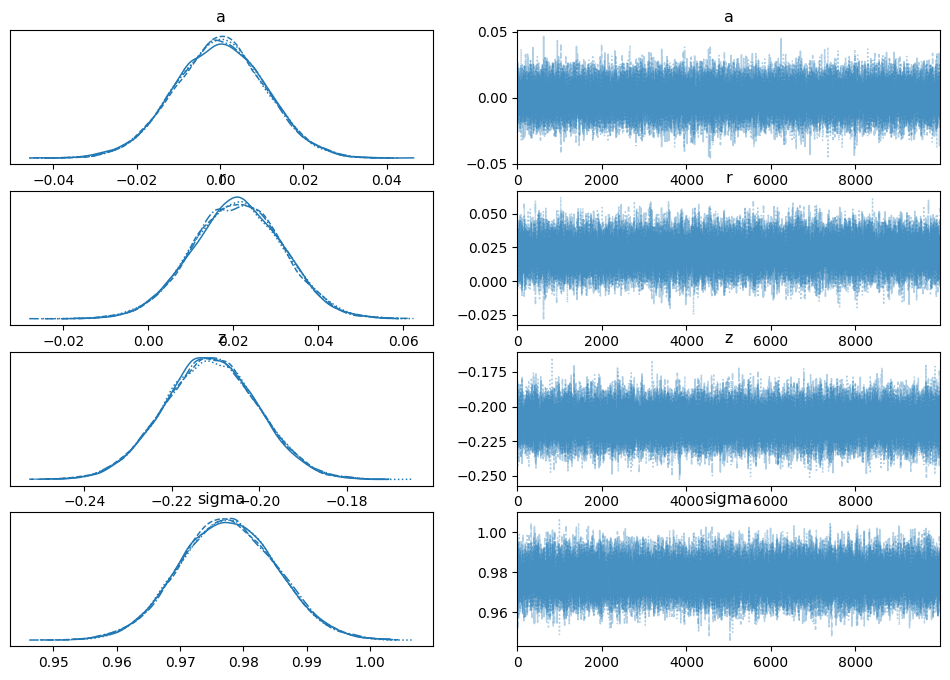

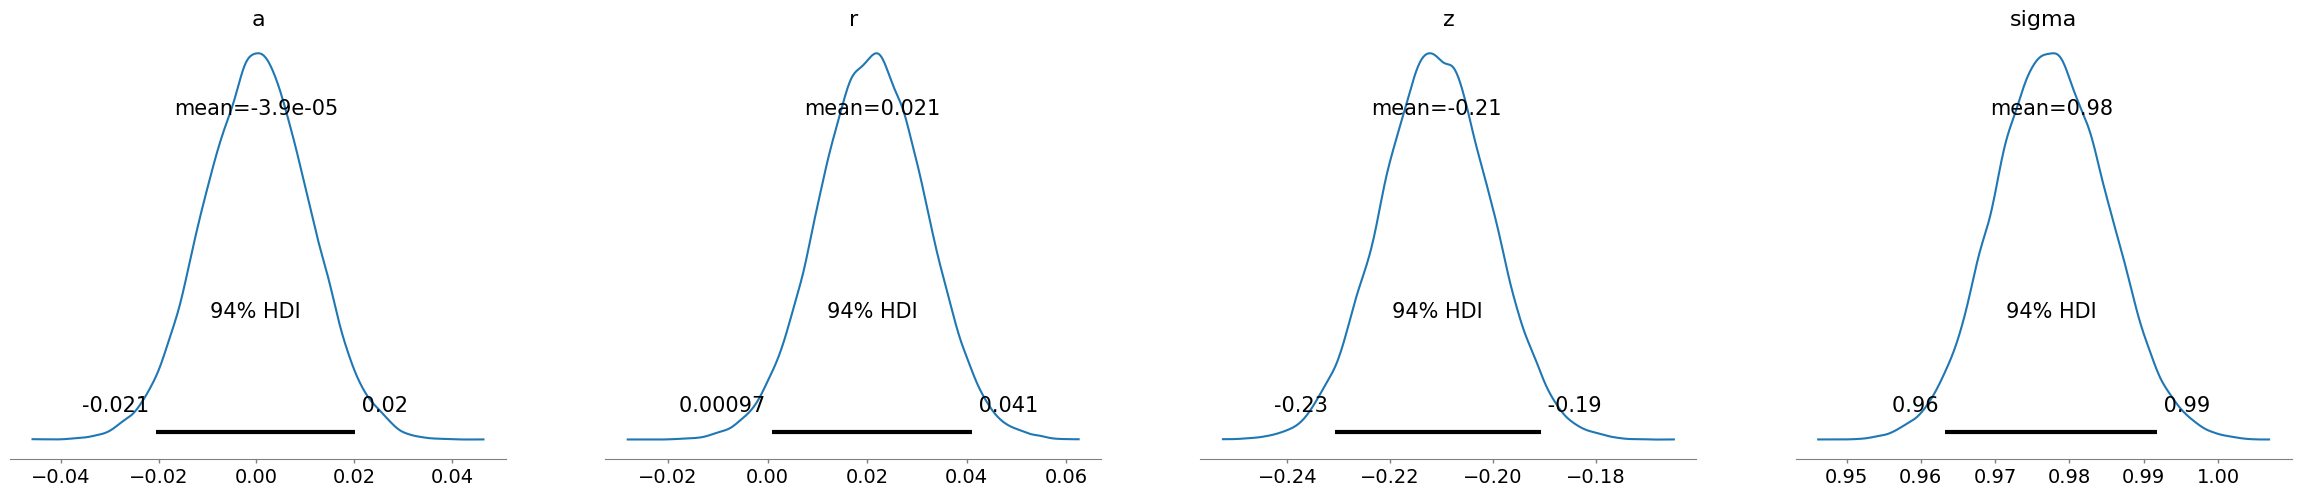

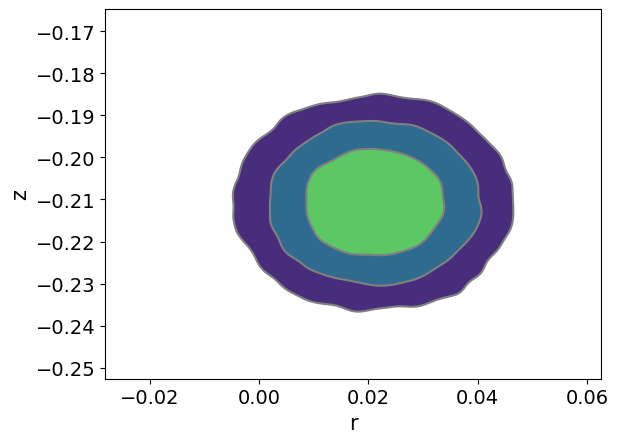

In [ ]:
# Analysis

# posterior analysis
az.summary(idata, var_names=["a", "r", "z", "sigma"])

# trace plots
az.plot_trace(idata, var_names=["a", "r", "z", "sigma"])

# posterior distributions
az.plot_posterior(idata, var_names=["a", "r", "z", "sigma"])

# plot of r vs z 
az.plot_pair(idata, var_names=["r", "z"], kind="kde")

In [3]:
# unstandardize r 

r_std = 0.021
uns_r = r_std * (y_std/x_std)
real_r = r_std * (yf_std/x_std)
print(uns_r)
print(real_r)

0.25638021281217566
0.25638021281217566
